In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import time
import math
import pyautogui
from sklearn.metrics.pairwise import euclidean_distances
def nothing(x):
    pass
cv2.namedWindow("Trackbars")
cv2.createTrackbar("bgSubThreshold", "Trackbars", 60, 200, nothing)
#cv2.createTrackbar("H_min", "Trackbars", 0, 179, nothing)
#cv2.createTrackbar("S_min", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("V_min", "Trackbars", 50, 255, nothing)
cv2.createTrackbar("H_max", "Trackbars", 179, 179, nothing)
#cv2.createTrackbar("S_max", "Trackbars", 255, 255, nothing)
#cv2.createTrackbar("V_max", "Trackbars", 255, 255, nothing)
cv2.createTrackbar("gamma","Trackbars",100,300,nothing)
def remove_background(crop_image):
    fgmask = bgModel.apply(crop_image, learningRate=0)
    kernel = np.ones((5, 5), np.uint8)
    #fgmask = cv2.erode(fgmask, kernel, iterations=1)
    #fgmask = cv2.dilate(fgmask, kernel, iterations=1)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)
    res = cv2.bitwise_and(crop_image, crop_image, mask=fgmask)
    return res
cap = cv2.VideoCapture(0)
isBgCaptured = 0
game = 0
x=0
y=0
while True:
    gamma_change = cv2.getTrackbarPos("gamma","Trackbars")/100
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma_change) * 255.0, 0, 255)
    bgSubThreshold = cv2.getTrackbarPos("bgSubThreshold", "Trackbars")
    #H_min = cv2.getTrackbarPos("H_min", "Trackbars")
    H_min = 0
    #S_min = cv2.getTrackbarPos("S_min", "Trackbars")
    S_min = 0
    V_min = cv2.getTrackbarPos("V_min", "Trackbars")
    H_max = cv2.getTrackbarPos("H_max", "Trackbars")
    #S_max = cv2.getTrackbarPos("S_max", "Trackbars")
    S_max = 255
    #V_max = cv2.getTrackbarPos("V_max", "Trackbars")
    V_max = 255
    lower_red = np.array([H_min, S_min, V_min])
    upper_red = np.array([H_max, S_max, V_max])
    ret,frame = cap.read()
    frame = cv2.flip(frame,1)
    frame = imutils.resize(frame,width=640)
    frame = cv2.LUT(frame, lookUpTable)
    frame = cv2.GaussianBlur(frame,(5,5),0)
    cv2.rectangle(frame, (320, 0), (640,240), (255,255,255), 2)
    crop_image = frame[0:240,320:640]
    if isBgCaptured == 1:
        img =  remove_background(crop_image)
        cv2.imshow('hehe',img)
        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        #cv2.imshow('hehe1',hsv)
        mask2 = cv2.inRange(hsv, lower_red, upper_red)
        #cv2.imshow("mask2", mask2)
        ret, thresh = cv2.threshold(mask2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU )
        #cv2.imshow("thresh", thresh)
        kernel = np.ones((5, 5), np.uint8)
        erotion = cv2.erode(thresh, kernel, iterations=2)
        dilation = cv2.dilate(erotion,kernel,iterations = 2)
        opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        cv2.imshow("closing", closing)
        contours = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #contours = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = imutils.grab_contours(contours)
    try:
        contour = max(contours, key=lambda x: cv2.contourArea(x))#contour
        drawing = np.zeros(crop_image.shape, np.uint8) 
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(crop_image, (x, y), (x + w, y + h), (255, 100, 255), 0)
        #approximation
        #contour = sorted ( contours, key = cv2.contourArea, reverse = True ) [ : 1000 ]
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.001*peri , True)
        screenCnt = approx   
        #text = "original, num_pts={}".format(len(approx))
        #cv2.putText(drawing, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,0.9, (0, 255, 0), 2)
        #cv2.drawContours(drawing, [screenCnt], -1, (255, 255, 255), 5)
        cv2.drawContours(crop_image, [screenCnt], -1, (255, 255, 255), 5)
        M = cv2.moments(contour)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        #cv2.circle(drawing, (cx, cy), 7, (255, 255, 255), -1)
        cv2.circle(crop_image, (cx, cy), 7, (255, 255, 255), -1)
        hull = cv2.convexHull(approx)
        # find the most extreme points in the convex hull
        extreme_top    = tuple(hull[hull[:, :, 1].argmin()][0])
        extreme_bottom = tuple(hull[hull[:, :, 1].argmax()][0])
        extreme_left   = tuple(hull[hull[:, :, 0].argmin()][0])
        extreme_right  = tuple(hull[hull[:, :, 0].argmax()][0])
        cv2.drawContours(drawing, [hull], -1, (0, 255, 255), 1)#
        M = [[cx,cy]]
        hull = hull.reshape(hull.shape[0],hull.shape[2])
        i = []
        for c in range(hull.shape[0]):
            a = hull[c,1]
            i = np.append(i,a)
        min_hull = min(i)
        a = np.where(i==min_hull)
        min_hull_index = a[0][0]
        min_x,min_y = hull[min_hull_index]
        MAX = max(euclidean_distances(hull,M))
        cv2.circle(crop_image, (cx,cy), int(MAX*0.4), [0, 0, 255], 2)
        #cv2.circle(drawing, (cx,cy), int(MAX*0.4), [0, 0, 255], 2)
        #cv2.imshow("Gestur", drawing)
        
        # find the center of the palm
        cX = int((extreme_left[0] + extreme_right[0]) / 2)
        cY = int((extreme_top[1] + extreme_bottom[1]) / 2)
        #print("Center point : " + str(tuple((cX,cY))))
        #cv2.drawContours(image, [hull], -1, (0, 255, 0), 2)
        cv2.circle(crop_image, (cX, cY), radius=5, color=(255,0,0), thickness=5)
        #cv2.circle(crop_image, extreme_top, radius=5, color=(0,0,255), thickness=5)
        #cv2.circle(crop_image, extreme_bottom, radius=5, color=(0,0,255), thickness=5)
        #cv2.circle(crop_image, extreme_left, radius=5, color=(0,0,255), thickness=5)
        #cv2.circle(crop_image, extreme_right, radius=5, color=(0,0,255), thickness=5)
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)        
        count_defects = 0
        #print(min_x)
        #print(min_y)
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            
            a = math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            b = math.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
            c = math.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
            angle = (math.acos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)) * 180) / 3.14 
            s = (a+b+c)/2
            ar = math.sqrt(s*(s-a)*(s-b)*(s-c))
            d = 2*ar/a
            tan = math.atan2((cy-min_y),(cy-min_x))*180/3.14
            
            if angle <= 90 and d > 45 and a>20  :                
                count_defects += 1
                cv2.circle(crop_image, far, 2, [0, 0, 255], -1)
                cv2.circle(crop_image, start, 5, [255, 0, 255], -1)
                cv2.circle(crop_image, end, 5, [255, 0, 255], -1)
                cv2.line(crop_image, (cx,cy) , end, [0, 25, 100], 2)
                cv2.line(crop_image, (cx,cy), start, [0, 25, 100], 2)
            if count_defects == 0 and d < 30  :
                zero = 0
            if count_defects == 0 and d > 30  :
                zero = 1    
            cv2.line(crop_image, start, end, [0, 25, 100], 2) 
        if game == 1:
            if count_defects == 1:
                cv2.putText(frame, "TWO", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,255), 5)
                """
                try:
                    pyautogui.press('up')
                except:
                    pass
                """
            elif count_defects == 2:
                cv2.putText(frame, "THREE", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,255), 5)
                """
                try:
                    pyautogui.press('down')
                except:
                    pass
                """
            elif count_defects == 3:
                cv2.putText(frame, "FOUR", (50, 50), cv2.FONT_HERSHEY_SIMPLEX,2 ,(255,0,255), 5)
                """
                try:
                    x, y = pyautogui.locateCenterOnScreen('exit.jpg')
                    pyautogui.moveTo(x, y, 2)
                    pyautogui.click(x, y)
                except:
                    pass
                """
            elif count_defects == 4:
                cv2.putText(frame, "FIVE", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,255), 5)
                """
                try:
                    x, y = pyautogui.locateCenterOnScreen('retry.jpg')
                    pyautogui.moveTo(x, y, 2)
                    pyautogui.click(x, y)
                except:
                    pass
                """
            elif count_defects == 0 and zero!= 0:
                cv2.putText(frame, "ONE", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,255),5)
                """
                try:
                    x, y = pyautogui.locateCenterOnScreen('level.jpg')
                    if x == 0:
                        x, y = pyautogui.locateCenterOnScreen('car.jpg')
                    if x == 0:
                        x, y = pyautogui.locateCenterOnScreen('enter.jpg')
                    pyautogui.moveTo(x, y, 2)
                    pyautogui.click(x, y)
                except:
                    pass
                """
            elif zero == 0:
                cv2.putText(frame, "ZERO", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,255),5)
            else:
                pass
        else:
            pass 
                
    except:
        pass
    cv2.imshow('img1',frame)
    key_press = cv2.waitKey(100)
    if key_press == ord('q'):
        break
    elif key_press == ord('b'):
        bgModel = cv2.createBackgroundSubtractorMOG2(30, bgSubThreshold,detectShadows=False)
        isBgCaptured = 1
        time.sleep(2)
    elif key_press == ord('r'):
        bgModel = None
        isBgCaptured = 0
        time.sleep(1)
    elif key_press == ord('z'):
        game = 1
    
cap.release()
cv2.destroyAllWindows

Original image shape - (549, 700, 3)
Gray image shape - (549, 700)
Number of Contours found = 1
Center point : (395, 277)
Count of fingers : 5


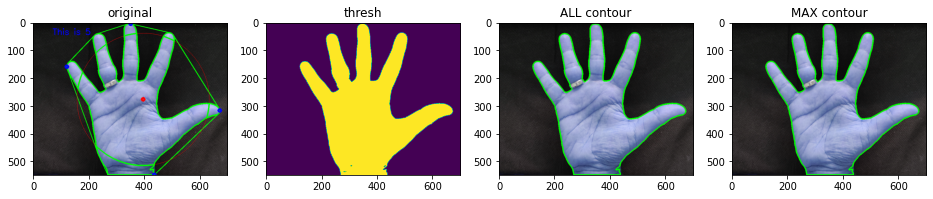

In [1]:
#------------------------------------------------------------
# SEGMENT, RECOGNIZE and COUNT fingers from a single frame
#------------------------------------------------------------

# organize imports
import cv2
import imutils
import numpy as np
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
#---------------------------------------------
# To segment the region of hand in the image
#---------------------------------------------
def segment(image, grayimage, threshold=75):
    # threshold the image to get the foreground which is the hand
    thresholded = cv2.threshold(grayimage, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:     
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        
        return (thresholded, segmented)
#---------------------------------------------
# To segment the region of hand in the image
#---------------------------------------------
def segment(image, grayimage, threshold=75):
    # threshold the image to get the foreground which is the hand
    thresholded = cv2.threshold(grayimage, threshold, 255, cv2.THRESH_BINARY)[1]
    print("Original image shape - " + str(image.shape))
    print("Gray image shape - " + str(grayimage.shape))

    # show the thresholded image
    plt.subplot(1,4,2)  
    plt.title("thresh")
    plt.imshow(thresholded)

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # analyze the contours
        print("Number of Contours found = " + str(len(cnts))) 
        cv2.drawContours(image, cnts, -1, (0, 255, 0), 3)
        plt.subplot(1,4,3) 
        plt.title("ALL contour")
        plt.imshow(image) 
        
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        cv2.drawContours(image, segmented, -1, (0, 255, 0), 3)
        plt.subplot(1,4,4) 
        plt.title("MAX contour")
        plt.imshow(image) 
        
        return (thresholded, segmented)
#--------------------------------------------------------------
# To count the number of fingers in the segmented hand region
#--------------------------------------------------------------
def count(image, thresholded, segmented):
    # find the convex hull of the segmented hand region
    # which is the maximum contour with respect to area
    chull = cv2.convexHull(segmented)
    cv2.drawContours(image, [chull], -1, (0, 255, 0), 2)
    #cv2.imshow("Convex Hull", image)
    # find the most extreme points in the convex hull
    extreme_top    = tuple(chull[chull[:, :, 1].argmin()][0])
    extreme_bottom = tuple(chull[chull[:, :, 1].argmax()][0])
    extreme_left   = tuple(chull[chull[:, :, 0].argmin()][0])
    extreme_right  = tuple(chull[chull[:, :, 0].argmax()][0])
    # find the center of the palm
    cX = int((extreme_left[0] + extreme_right[0]) / 2)
    cY = int((extreme_top[1] + extreme_bottom[1]) / 2)
    print("Center point : " + str(tuple((cX,cY))))
    cv2.drawContours(image, [chull], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), radius=5, color=(255,0,0), thickness=5)
    cv2.circle(image, extreme_top, radius=5, color=(0,0,255), thickness=5)
    cv2.circle(image, extreme_bottom, radius=5, color=(0,0,255), thickness=5)
    cv2.circle(image, extreme_left, radius=5, color=(0,0,255), thickness=5)
    cv2.circle(image, extreme_right, radius=5, color=(0,0,255), thickness=5)
    
    

    # find the maximum euclidean distance between the center of the palm
    # and the most extreme points of the convex hull
    distances = pairwise.euclidean_distances([(cX, cY)], Y=[extreme_left, extreme_right, extreme_top, extreme_bottom])[0]
    max_distance = distances[distances.argmax()]

    # calculate the radius of the circle with 80% of the max euclidean distance obtained
    radius = int(0.8 * max_distance)

    # find the circumference of the circle
    circumference = (2 * np.pi * radius)

    # initialize circular_roi with same shape as thresholded image
    circular_roi = np.zeros(thresholded.shape[:2], dtype="uint8")
    
    # draw the circular ROI with radius and center point of convex hull calculated above
    cv2.circle(image, (cX, cY), radius, 255, 1)
    cv2.circle(circular_roi, (cX, cY), radius, 255, 1)
    
    # take bit-wise AND between thresholded hand using the circular ROI as the mask
    # which gives the cuts obtained using mask on the thresholded hand image
    circular_roi = cv2.bitwise_and(thresholded, thresholded, mask=circular_roi)
    cv2.imshow("Bitwise AND", circular_roi)
    # compute the contours in the circular ROI
    (cnts, _) = cv2.findContours(circular_roi.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(image, cnts, -1, (0, 255, 0), 3)
    count = 0
    
    for i, c in enumerate(cnts):

        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)

        # increment the count of fingers only if -
        # 1. The contour region is not the wrist (bottom area)
        # 2. The number of points along the contour does not exceed
        #     25% of the circumference of the circular ROI
        if ((cY + (cY * 0.25)) > (y + h)) and ((circumference * 0.25) > c.shape[0]):
            count += 1
    cntsSorted = sorted(cnts, key=lambda x: cv2.contourArea(x))
    print("Count of fingers : " + str(len(cntsSorted[1:])))
    cv2.imshow("Extreme Points in Convex Hull", image)
    return count

#-----------------
# MAIN FUNCTION
#-----------------
if __name__ == "__main__":
    # get the current frame
    frame = cv2.imread("resources/hand-sample.jpg")
    plt.figure(figsize=(16,8))
    # resize the frame
    frame = imutils.resize(frame, width=700)

    # clone the frame
    clone = frame.copy()

    # get the height and width of the frame
    (height, width) = frame.shape[:2]

    # convert the frame to grayscale and blur it
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # segment the hand region
    hand = segment(clone, gray)

    # check whether hand region is segmented
    if hand is not None:
        # if yes, unpack the thresholded image and segmented contour
        (thresholded, segmented) = hand
        # count the number of fingers
        fingers = count(clone, thresholded, segmented)
        cv2.putText(clone, "This is " + str(fingers), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    plt.subplot(1,4,1)
    plt.title("original")
    plt.imshow(clone)

    cv2.waitKey(0)
    cv2.destroyAllWindows()